<a href="https://colab.research.google.com/github/zkoymen/house_price/blob/main/house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sanfis

In [151]:
import numpy as np
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sanfis import SANFIS
import pandas as pd
import matplotlib.pyplot as plt

# Load California Housing dataset
data = fetch_california_housing()

# First, let's find our variables

In [152]:
# Feature names
feature_names = data.feature_names
print("Feature Names:", feature_names)

Feature Names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Data Exploration to Identify what membership funcs to use

In [153]:
# Convert to pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target  # Add the target to the DataFrame
df = df.drop(columns=['AveBedrms'])

# Display the first few rows of the DataFrame
print(df.head())
print(df.tail())

   MedInc  HouseAge  AveRooms  Population  AveOccup  Latitude  Longitude  \
0  8.3252      41.0  6.984127       322.0  2.555556     37.88    -122.23   
1  8.3014      21.0  6.238137      2401.0  2.109842     37.86    -122.22   
2  7.2574      52.0  8.288136       496.0  2.802260     37.85    -122.24   
3  5.6431      52.0  5.817352       558.0  2.547945     37.85    -122.25   
4  3.8462      52.0  6.281853       565.0  2.181467     37.85    -122.25   

   MedHouseVal  
0        4.526  
1        3.585  
2        3.521  
3        3.413  
4        3.422  
       MedInc  HouseAge  AveRooms  Population  AveOccup  Latitude  Longitude  \
20635  1.5603      25.0  5.045455       845.0  2.560606     39.48    -121.09   
20636  2.5568      18.0  6.114035       356.0  3.122807     39.49    -121.21   
20637  1.7000      17.0  5.205543      1007.0  2.325635     39.43    -121.22   
20638  1.8672      18.0  5.329513       741.0  2.123209     39.43    -121.32   
20639  2.3886      16.0  5.254717      13

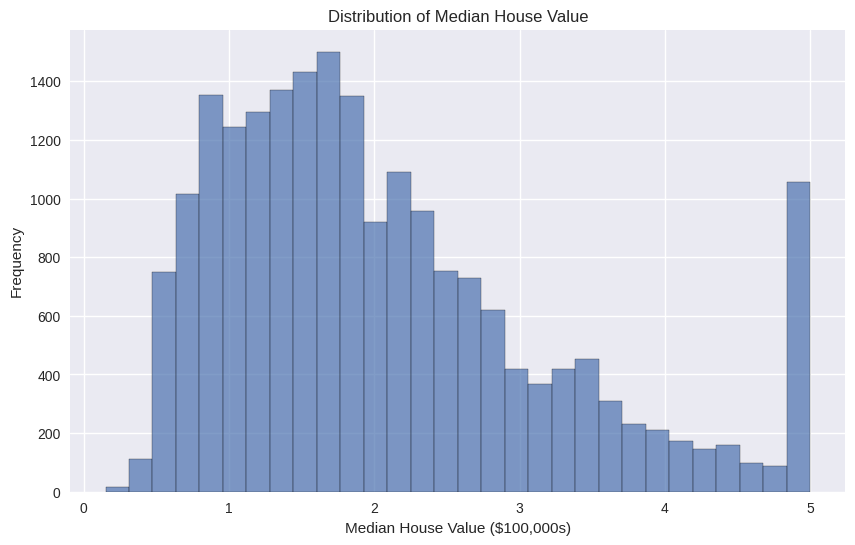

In [154]:
plt.figure(figsize=(10, 6))
plt.hist(df['MedHouseVal'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value ($100,000s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


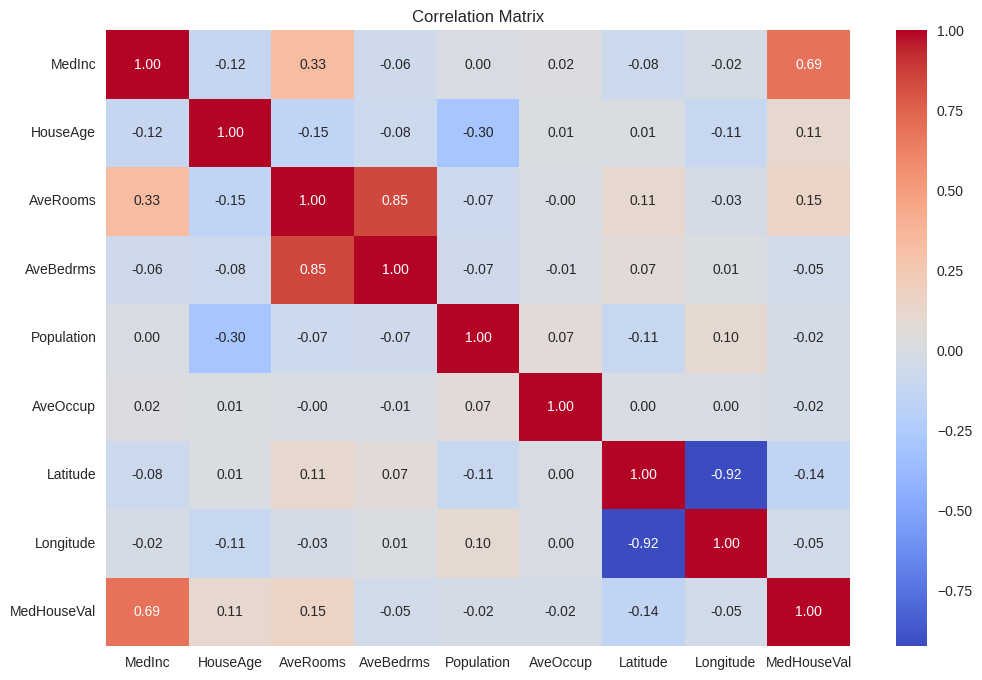

In [123]:
import seaborn as sns

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


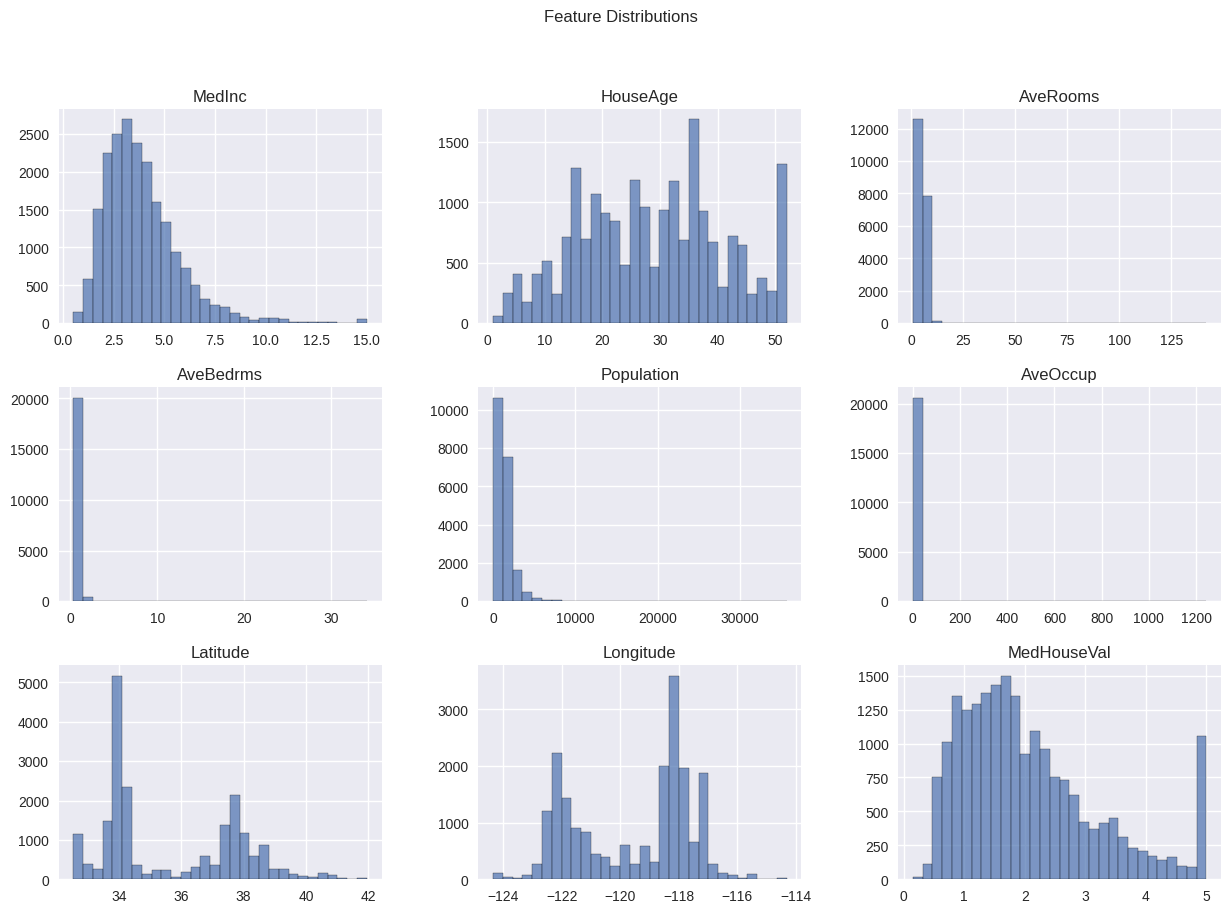

In [124]:
df.hist(bins=30, figsize=(15, 10), edgecolor='k', alpha=0.7)
plt.suptitle('Feature Distributions')
plt.show()


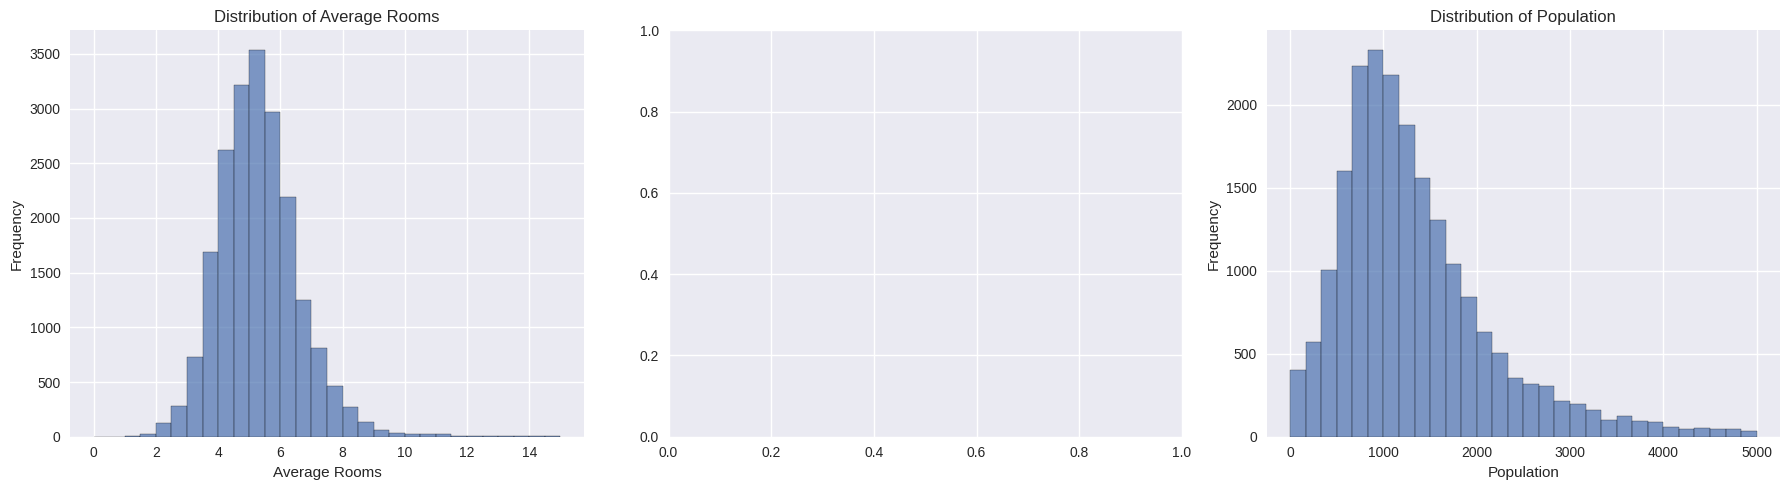

In [144]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Average Rooms
axs[0].hist(df['AveRooms'], bins=30, edgecolor='k', alpha=0.7, range=(0, 15))
axs[0].set_title('Distribution of Average Rooms')
axs[0].set_xlabel('Average Rooms')
axs[0].set_ylabel('Frequency')


# Population
axs[2].hist(df['Population'], bins=30, edgecolor='k', alpha=0.7, range=(0, 5000))
axs[2].set_title('Distribution of Population')
axs[2].set_xlabel('Population')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

!!! From the graphs above we cannot say anything about **average occupation**, which indicated the household number. So in order to get to real trend, I have cutten off outliers as seen below.

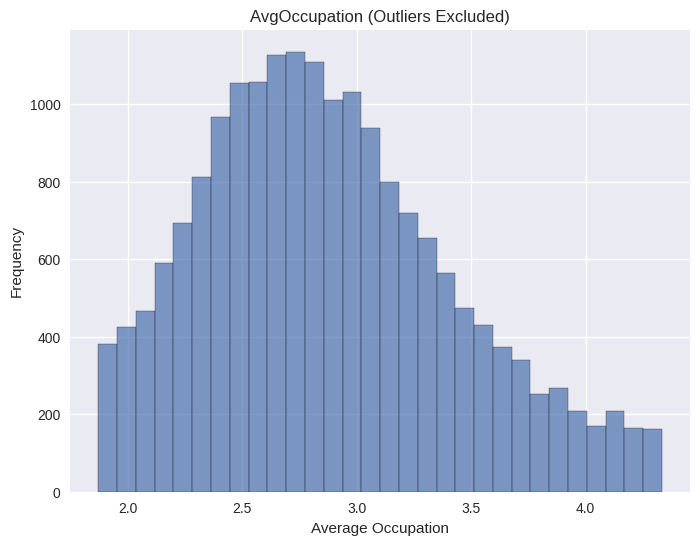

In [126]:
lower_percentile = 5
upper_percentile = 95

lower_limit = df['AveOccup'].quantile(lower_percentile / 100)
upper_limit = df['AveOccup'].quantile(upper_percentile / 100)

filtered_data = df[(df['AveOccup'] >= lower_limit) & (df['AveOccup'] <= upper_limit)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_data['AveOccup'], bins=30, edgecolor='k', alpha=0.7)
plt.title('AvgOccupation (Outliers Excluded)')
plt.xlabel('Average Occupation')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()



*   MedIncome is bell-shaped, thus will be using Gaussian for that one. (2)
*   HouseAge is a little volatile so we can use Gaussian and for starters (5) functions. (Later we will adjust all of these parameters.)
*   For Population, since it is left-skewed we could use Trapezodial. But it is not available in sanfis module, thus using Gaussian. (3)
*   For AvgRooms, will be using Gaussian. (2)
*   Since AvgBedrooms does not inform us very much, we won't be using that as a variable.
*   For latitude and longitude we will have Gaussian to catch it better. Since they are both bimodal we will use 2 functions. (2)
*   Finally, for AvgOccupation, we will start with 3 Gaussian functions.


In [155]:
ratio_train = 0.7
ratio_test = 0.15
ratio_valid = 0.15

train_size = int(len(df) * ratio_train)
valid_size = int(len(df) * ratio_valid)
test_size = len(df) - train_size - valid_size

train_data, valid_data, test_data = df.iloc[:train_size], df.iloc[train_size:train_size + valid_size], df[train_size + valid_size: ]

X_train = train_data.drop('MedHouseVal', axis=1)
y_train = train_data["MedHouseVal"]

X_valid = valid_data.drop('MedHouseVal', axis=1)
y_valid = valid_data["MedHouseVal"]

X_test = test_data.drop('MedHouseVal', axis=1)
y_test = test_data["MedHouseVal"]


X_train = X_train[:len(X_train)//2]
y_train = y_train[:len(y_train)//2]
X_valid = X_valid[:len(X_valid)//2]
y_valid = y_valid[:len(y_valid)//2]


In [156]:
y_valid.head()

14447    5.00001
14448    4.50000
14449    3.32400
14450    3.94400
14451    3.11900
Name: MedHouseVal, dtype: float64

In [157]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_valid = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


params = [
      {'function': 'gaussian', #medInc
        'n_memb': 2,
        'params': {'mu': {'value':[0.0, 1.0], 'trainable': True},
                    'sigma': {'value': [1.0, 1.8], 'trainable': True}}},
      {'function': 'gaussian',  #HouseAge
        'n_memb': 3,
        'params': {'mu': {'value': [-2.0, 0.0, 1.5], 'trainable': True},
                    'sigma': {'value': [1.0, 0.5, 1.0], 'trainable': True}}},
      {'function': 'gaussian', #AvrRoom
        'n_memb': 2,
        'params': {'mu': {'value':[ 0.0, 1.0], 'trainable': True},
                    'sigma': {'value': 4.94, 'trainable': True}}},
      {'function': 'gaussian',  #population
        'n_memb': 3,
        'params': {'mu': {'value': [-2.0, 0.0, 1.5], 'trainable': True},
                    'sigma': {'value':  [1.0, 0.5, 1.0], 'trainable': True}}},
      {'function': 'gaussian', #average Occupation
        'n_memb': 3,
        'params': {'mu': {'value': [-2.0, 0.0, 1.5], 'trainable': True},
                    'sigma': {'value':  [1.0, 0.5, 1.0], 'trainable': True}}},
      {'function': 'gaussian', #latitude
        'n_memb': 2,
        'params': {'mu': {'value': [0.0, 1.5], 'trainable': True},
                    'sigma': {'value': [1.0, 1.0], 'trainable': True}}},
      {'function': 'gaussian', #longitude
        'n_memb': 2,
        'params': {'mu': {'value': [0.0, 1.5], 'trainable': True},
                    'sigma': {'value': [1.0, 1.0], 'trainable': True}}}
]



Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 100.0/100 [04:02<00:00,  2.42s/epochs, train_loss=0.205, valid_loss=0.534]


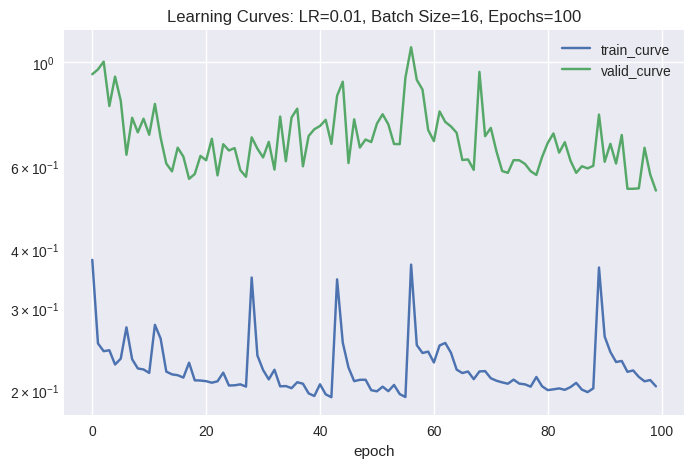

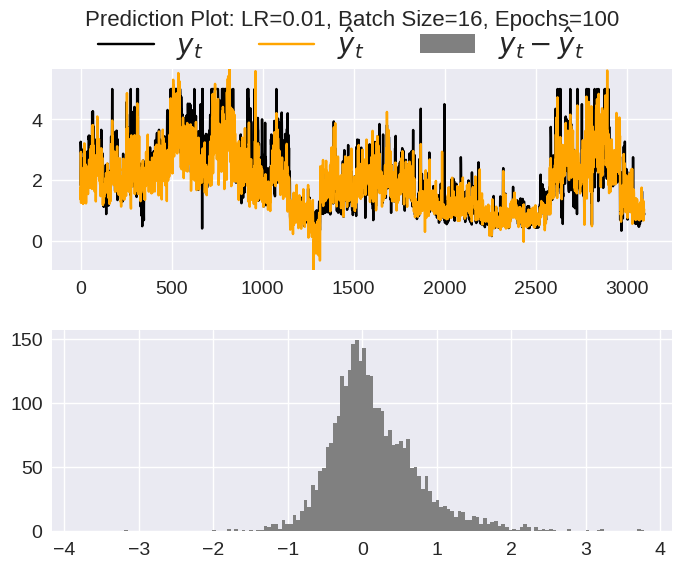

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 200.0/200 [07:59<00:00,  2.40s/epochs, train_loss=0.213, valid_loss=0.722]


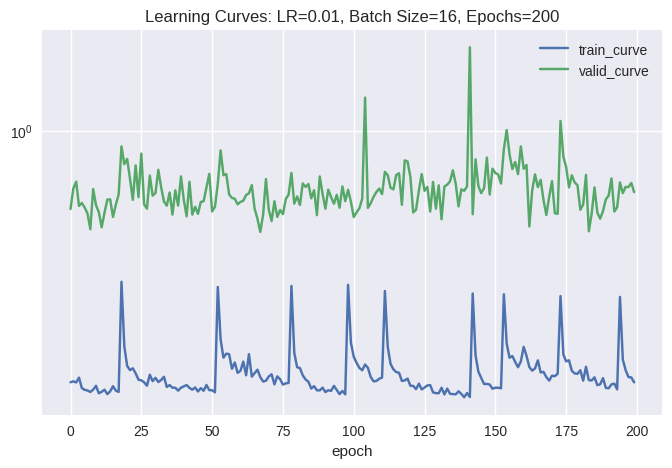

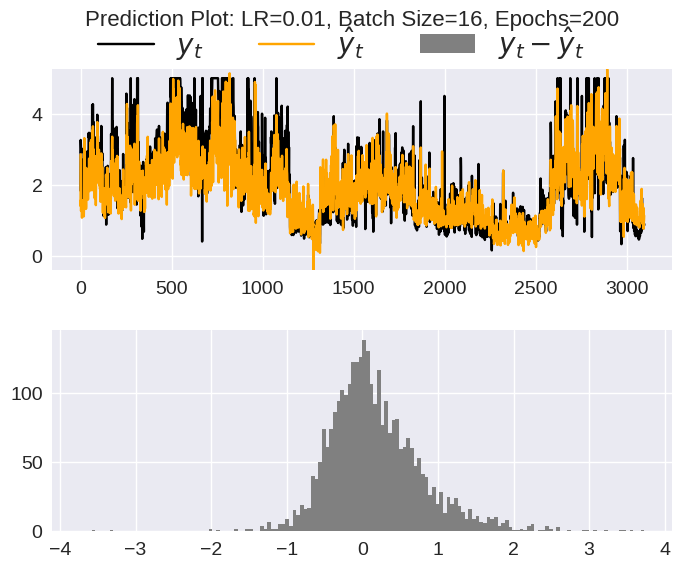

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 100.0/100 [02:19<00:00,  1.39s/epochs, train_loss=0.194, valid_loss=0.633]


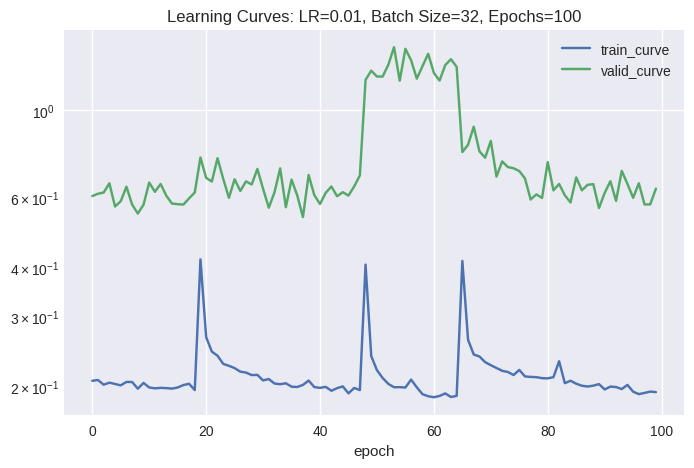

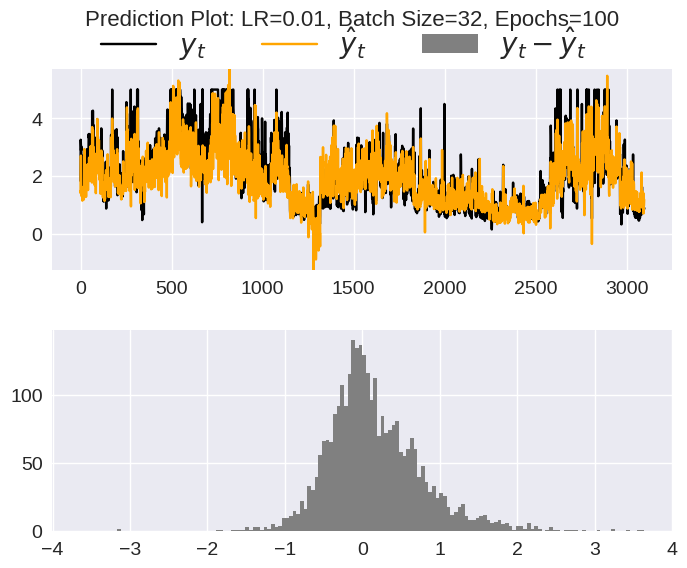

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 200.0/200 [04:30<00:00,  1.35s/epochs, train_loss=0.219, valid_loss=0.756]


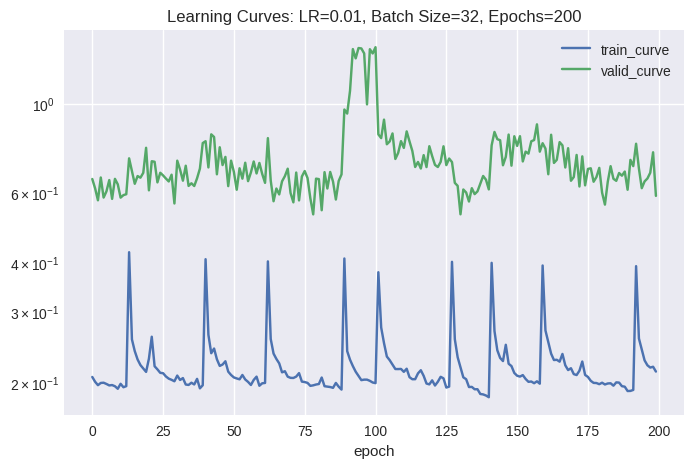

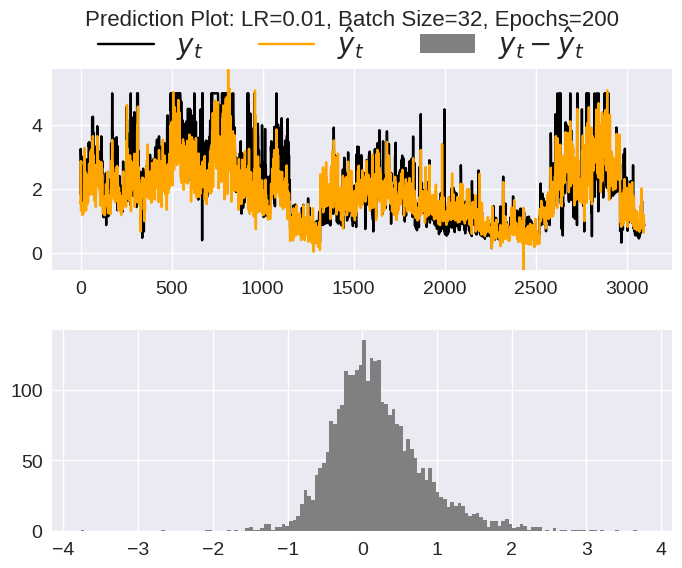

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 100.0/100 [03:58<00:00,  2.38s/epochs, train_loss=0.189, valid_loss=0.681]


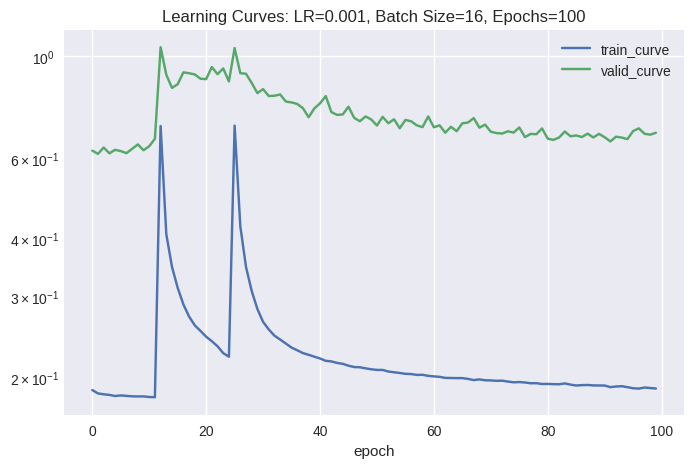

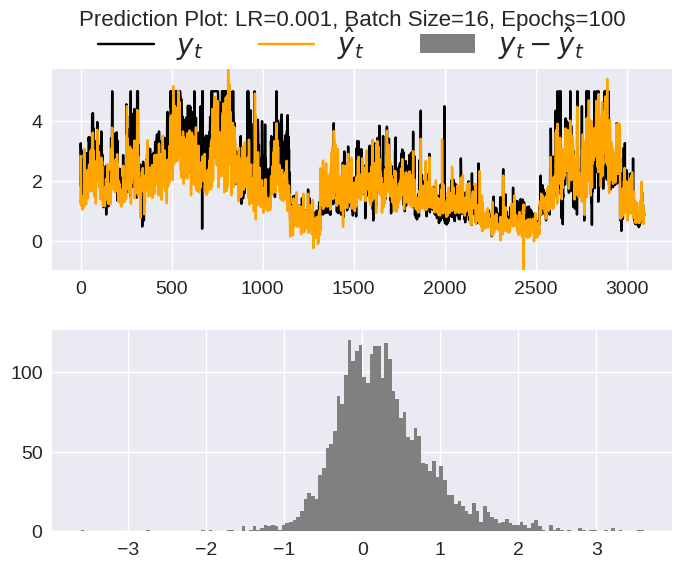

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 200.0/200 [08:12<00:00,  2.46s/epochs, train_loss=0.186, valid_loss=0.691]


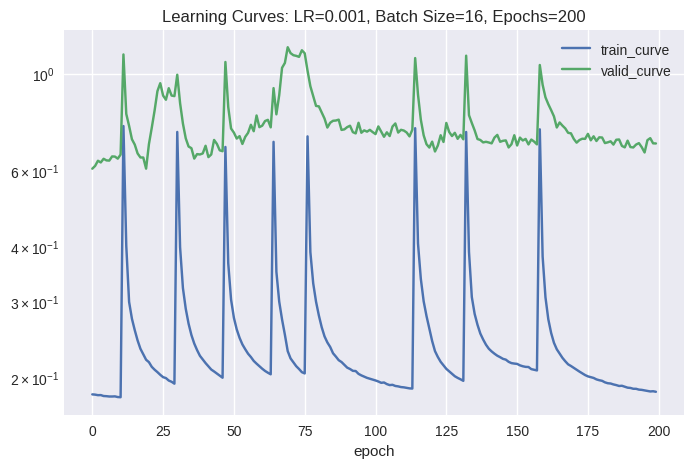

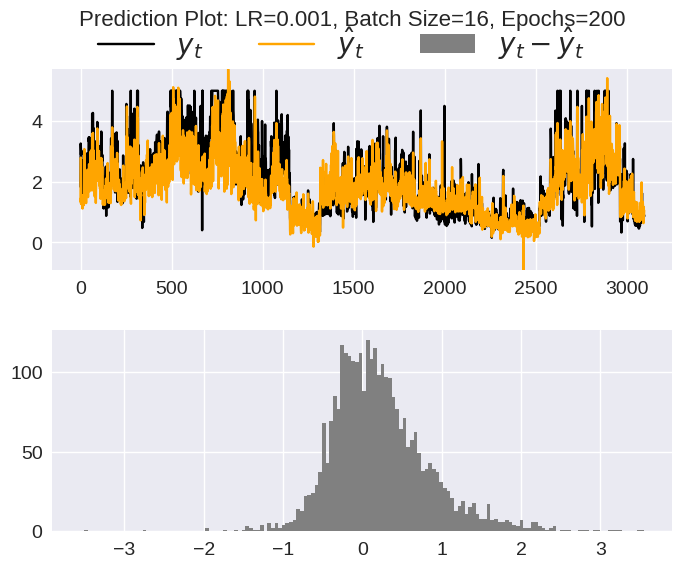

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 100.0/100 [02:19<00:00,  1.39s/epochs, train_loss=0.219, valid_loss=1.01]


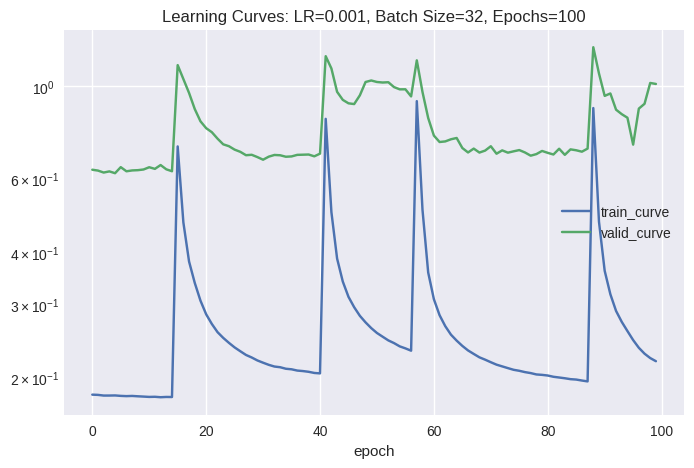

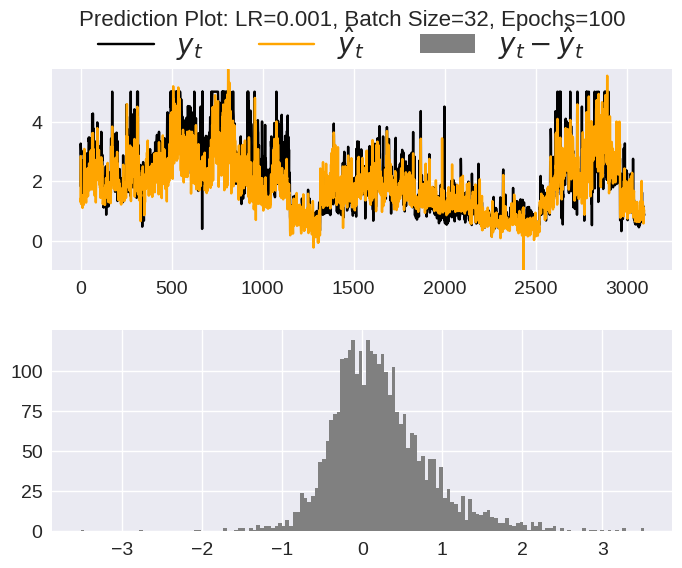

Train s-anfis on 7223 samples, validate on 1548 samples


Training Loop: 100%|##########| 200.0/200 [04:39<00:00,  1.40s/epochs, train_loss=0.184, valid_loss=0.804]


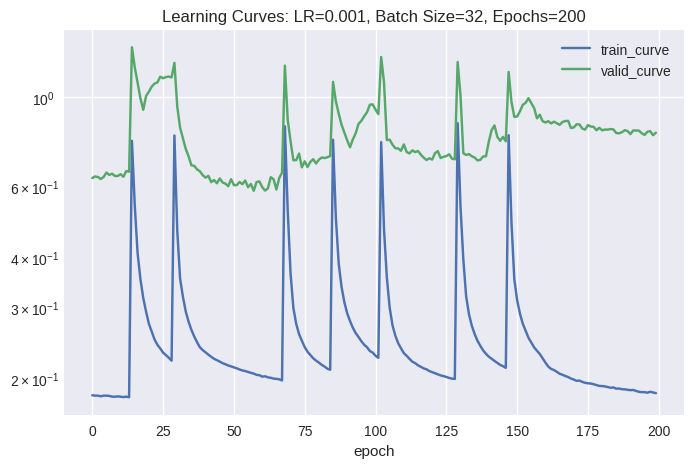

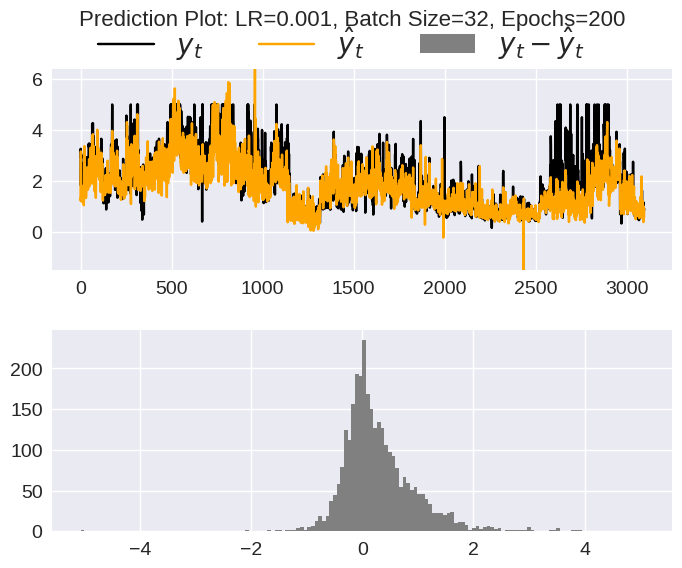

{'Learning Rate': 0.01, 'Batch Size': 16, 'Epochs': 100, 'Optimizer': 'Adam', 'Test Loss': 0.3950141966342926}
{'Learning Rate': 0.01, 'Batch Size': 16, 'Epochs': 200, 'Optimizer': 'Adam', 'Test Loss': 0.4261845648288727}
{'Learning Rate': 0.01, 'Batch Size': 32, 'Epochs': 100, 'Optimizer': 'Adam', 'Test Loss': 0.42075690627098083}
{'Learning Rate': 0.01, 'Batch Size': 32, 'Epochs': 200, 'Optimizer': 'Adam', 'Test Loss': 0.4398233890533447}
{'Learning Rate': 0.001, 'Batch Size': 16, 'Epochs': 100, 'Optimizer': 'Adam', 'Test Loss': 0.4663821756839752}
{'Learning Rate': 0.001, 'Batch Size': 16, 'Epochs': 200, 'Optimizer': 'Adam', 'Test Loss': 0.44370037317276}
{'Learning Rate': 0.001, 'Batch Size': 32, 'Epochs': 100, 'Optimizer': 'Adam', 'Test Loss': 0.43857458233833313}
{'Learning Rate': 0.001, 'Batch Size': 32, 'Epochs': 200, 'Optimizer': 'Adam', 'Test Loss': 0.5112519264221191}


In [159]:
from sanfis import plottingtools as pt
import os

#Initialize the model
n_features = X_train.shape[1]
model = SANFIS(n_input=7, membfuncs=params, scale='Std', to_device="cpu")

#Loss function and optimizer
criterion = torch.nn.MSELoss().to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
num_epochs = [100, 200]

X_train = X_train.to("cpu")
y_train = y_train.to("cpu")
X_valid = X_valid.to("cpu")
y_valid = y_valid.to("cpu")

results = []

plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # fit model
                history = model.fit(train_data=[X_train, y_train],
                                    valid_data=[X_valid, y_valid],
                                    optimizer=optimizer,
                                    loss_function=criterion,
                                    epochs=epochs,
                                    batch_size=batch_size)

                # Evaluate the model on test data and record results
                predictions = model.predict(X_test)
                loss = criterion(predictions, y_test).item()

                plot_path = os.path.join(plot_dir, f'learning_curve_lr_{lr}_batch_{batch_size}_epochs_{epochs}.png')
                pt.plt_learningcurves(history, title=f'Learning Curves: LR={lr}, Batch Size={batch_size}, Epochs={epochs}', save_path=plot_path)
                plot_path = os.path.join(plot_dir, f'prediction_lr_{lr}_batch_{batch_size}_epochs_{epochs}.png')
                pt.plt_prediction(y_test, predictions, title=f'Prediction Plot: LR={lr}, Batch Size={batch_size}, Epochs={epochs}', save_path=plot_path)

                results.append({
                    'Learning Rate': lr,
                    'Batch Size': batch_size,
                    'Epochs': epochs,
                    'Optimizer': "Adam",
                    'Test Loss': loss
                })

# Print or save the results for further analysis
for result in results:
    print(result)